In [63]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from confusion_matrix_pretty_print import pretty_plot_confusion_matrix
from pandas import DataFrame
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
%matplotlib inline

In [3]:
class_labels = {
    'on': 0,
    'off': 1,
    'left': 2,
    'right': 3,
    'up': 4,
    'down': 5,
    'zero': 6,
    'one': 7,
    'two': 8,
    'three': 9,
    'four': 10,
    'five': 11,
    'six': 12,
    'seven': 13,
    'eight': 14,
    'nine': 15,
    'other': 16
}

In [4]:
TRAINING_EPOCHS = 200
LEARNING_RATE = 0.0001
BATCH_SIZE = 32

In [7]:
clean_X = np.load('clean-features.npy')
clean_Y = np.load('clean-labels.npy')

noisy_X = np.load('noisy-features.npy')
noisy_Y = np.load('noisy-labels.npy')

In [8]:
clean_X.shape

(41849, 20, 44)

In [9]:
clean_examples_count = clean_X.shape[0]

In [10]:
noisy_X.shape

(41849, 20, 44)

In [11]:
noisy_examples_count = noisy_X.shape[0]

In [12]:
# Randomly shuffle primary sets
clean_set_permutation = np.random.permutation(clean_examples_count)
clean_X = clean_X[clean_set_permutation]
clean_Y = clean_Y[clean_set_permutation]

noisy_set_permutation = np.random.permutation(noisy_examples_count)
noisy_X = noisy_X[noisy_set_permutation]
noisy_Y = noisy_Y[noisy_set_permutation]

In [13]:
# Shuffle 50% of noisy examples with clean set. The rest will represent "target" distribution
noisy_set_split_point = int(np.floor(noisy_examples_count * 0.75))

noisy_X_to_shuffle, target_X = noisy_X[:noisy_set_split_point], noisy_X[noisy_set_split_point:]
noisy_Y_to_shuffle, target_Y = noisy_Y[:noisy_set_split_point], noisy_Y[noisy_set_split_point:]

shuffled_X = np.concatenate((clean_X, noisy_X_to_shuffle), axis=0)
shuffled_Y = np.concatenate((clean_Y, noisy_Y_to_shuffle), axis=0)

shuffled_examples_count = shuffled_X.shape[0]
shuffled_set_permutation = np.random.permutation(shuffled_examples_count)
shuffled_X = shuffled_X[shuffled_set_permutation]
shuffled_Y = shuffled_Y[shuffled_set_permutation]

In [14]:
# Finally, split into train, bridge, dev and test set
shuffled_set_split_point = int(np.floor(shuffled_examples_count * 0.9))
train_X, bridge_X = shuffled_X[:shuffled_set_split_point], shuffled_X[shuffled_set_split_point:]
train_Y, bridge_Y = shuffled_Y[:shuffled_set_split_point], shuffled_Y[shuffled_set_split_point:]

target_examples_count = target_X.shape[0]
target_set_split_point = target_examples_count // 2
dev_X, test_X = target_X[:target_set_split_point], target_X[target_set_split_point:]
dev_Y, test_Y = target_Y[:target_set_split_point], target_Y[target_set_split_point:]

In [13]:
train_X.shape

(65911, 20, 44)

In [14]:
train_Y.shape

(65911, 17)

In [15]:
bridge_X.shape

(7324, 20, 44)

In [16]:
bridge_Y.shape

(7324, 17)

In [17]:
dev_X.shape

(5231, 20, 44)

In [18]:
dev_Y.shape

(5231, 17)

In [19]:
test_X.shape

(5232, 20, 44)

In [20]:
test_Y.shape

(5232, 17)

In [21]:
def model():
    
    X_input = tf.keras.layers.Input(shape=(20,44))
    X = tf.keras.layers.LayerNormalization() (X_input)
    X = tf.keras.layers.LSTM(units=44, activation='relu', dropout=0.3, return_sequences=True) (X)
    X = tf.keras.layers.Flatten() (X)
    X = tf.keras.layers.BatchNormalization() (X)
    X = tf.keras.layers.Dense(32, activation='sigmoid') (X)
    X = tf.keras.layers.Dense(17, activation='softmax') (X)
    
    model = tf.keras.Model(inputs=X_input, outputs=X, name='LSTM')
    
    return model

In [22]:
model = model()

In [23]:
model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 44)]          0         
_________________________________________________________________
layer_normalization (LayerNo (None, 20, 44)            88        
_________________________________________________________________
lstm (LSTM)                  (None, 20, 44)            15664     
_________________________________________________________________
flatten (Flatten)            (None, 880)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 880)               3520      
_________________________________________________________________
dense (Dense)                (None, 32)                28192     
_________________________________________________________________
dense_1 (Dense)              (None, 17)                561    

In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

metrics = [ tf.keras.metrics.CategoricalAccuracy(name='accuracy'), ]

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)

In [25]:
history = model.fit(train_X, train_Y, batch_size=BATCH_SIZE, epochs=TRAINING_EPOCHS, shuffle=True)

Epoch 1/200
2060/2060 [==============================] - 38s 17ms/step - loss: 1.9520 - accuracy: 0.4729
Epoch 2/200
2060/2060 [==============================] - 31s 15ms/step - loss: 1.2185 - accuracy: 0.6278
Epoch 3/200
2060/2060 [==============================] - 32s 15ms/step - loss: 0.8984 - accuracy: 0.7525
Epoch 4/200
2060/2060 [==============================] - 34s 17ms/step - loss: 0.6887 - accuracy: 0.8208
Epoch 5/200
2060/2060 [==============================] - 29s 14ms/step - loss: 0.5548 - accuracy: 0.8576
Epoch 6/200
2060/2060 [==============================] - 26s 12ms/step - loss: 0.4578 - accuracy: 0.8809
Epoch 7/200
2060/2060 [==============================] - 25s 12ms/step - loss: 0.3947 - accuracy: 0.8961
Epoch 8/200
2060/2060 [==============================] - 25s 12ms/step - loss: 0.3468 - accuracy: 0.9085
Epoch 9/200
2060/2060 [==============================] - 30s 14ms/step - loss: 0.3110 - accuracy: 0.9167
Epoch 10/200
2060/2060 [==============================]

In [26]:
epochs = range(1, TRAINING_EPOCHS+1)

<function matplotlib.pyplot.show(close=None, block=None)>

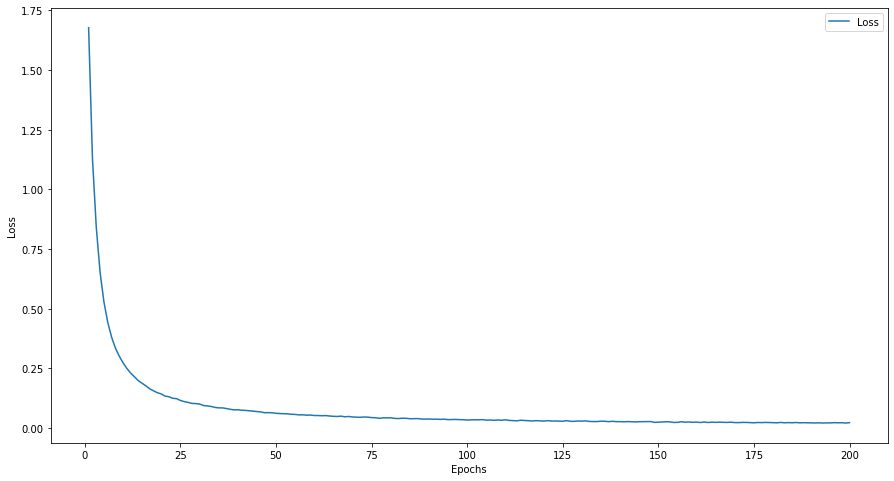

In [27]:
loss = history.history['loss']
plt.figure(figsize=(15,8))
plt.plot(epochs, loss, label="Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

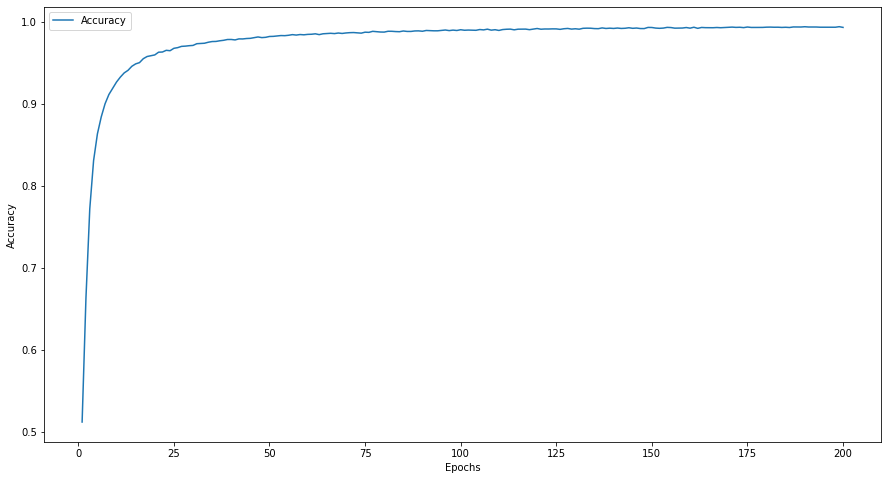

In [28]:
accuracy = history.history['accuracy']
plt.figure(figsize=(15,8))
plt.plot(epochs, accuracy, label="Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show

In [29]:
bridge_loss, bridge_accuracy = model.evaluate(bridge_X, bridge_Y, batch_size=BATCH_SIZE, verbose=2)

229/229 - 1s - loss: 0.0223 - accuracy: 0.9944


In [30]:
dev_loss, dev_accuracy = model.evaluate(dev_X, dev_Y, batch_size=BATCH_SIZE, verbose=2)

164/164 - 1s - loss: 0.0253 - accuracy: 0.9912


In [31]:
training_accuracy = history.history['accuracy'][-1]

In [32]:
print(f'Training accuracy: {training_accuracy}')
print(f'Bridge accuracy: {bridge_accuracy}')
print(f'Dev accuracy: {dev_accuracy}')

Training accuracy: 0.9928236603736877
Bridge accuracy: 0.9944019913673401
Dev accuracy: 0.9912062883377075


In [33]:
model.save('trained-model')

INFO:tensorflow:Assets written to: trained-model/assets


In [5]:
model = tf.keras.models.load_model('trained-model')

In [15]:
predictions = model.predict(test_X)

In [20]:
confusion_matrix_columns = [key for key in class_labels.keys()]

In [49]:
predictions_converted = np.argmax(predictions, axis=1)

In [50]:
labels_converted = np.argmax(test_Y, axis=1)

In [51]:
confusion_matrix_ = confusion_matrix(labels_converted, predictions_converted)

In [40]:
confusion_matrix_df = DataFrame(confusion_matrix_, index=confusion_matrix_columns, columns=confusion_matrix_columns)

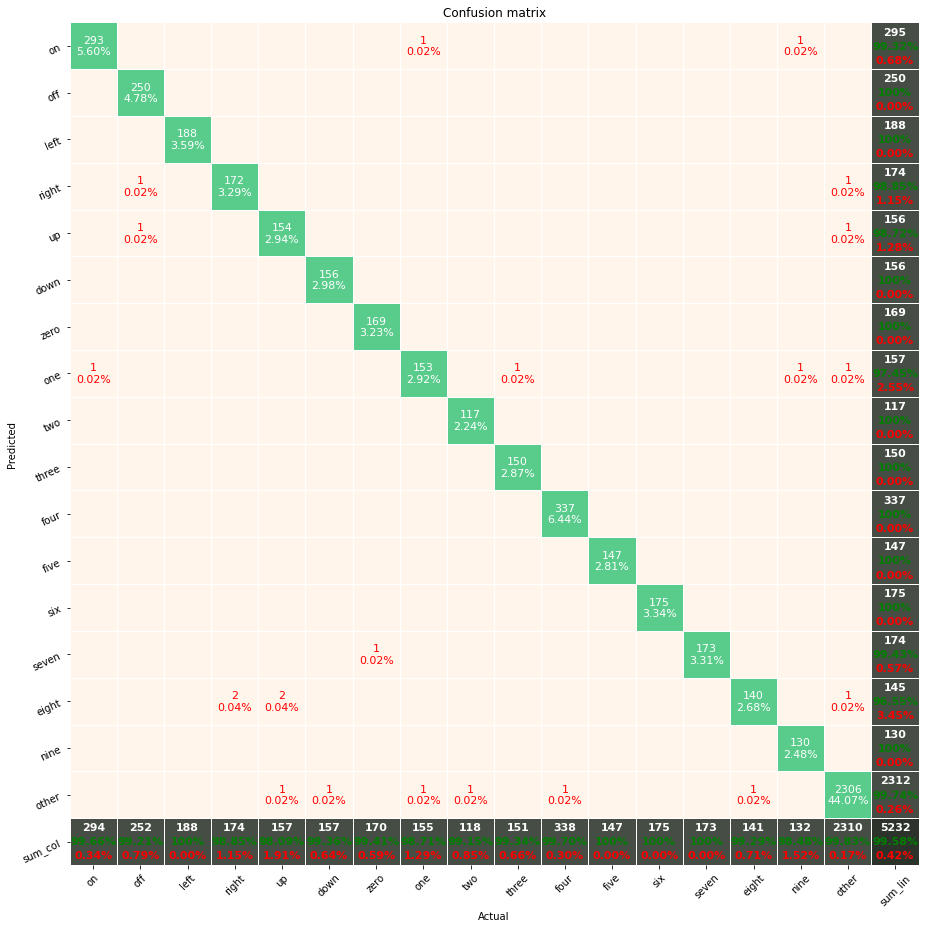

In [41]:
pretty_plot_confusion_matrix(confusion_matrix_df, annot=True, cmap="Oranges", figsize=[13,13])

In [52]:
test_accuracy = accuracy_score(labels_converted, predictions_converted)

In [53]:
test_accuracy

0.9957951070336392

In [68]:
macro_precision = precision_score(labels_converted, predictions_converted, average='weighted')

In [69]:
macro_precision

0.9958321450754103

In [66]:
macro_recall = recall_score(labels_converted, predictions_converted, average='weighted')

In [67]:
macro_recall

0.9957951070336392

In [64]:
f1_score = f1_score(labels_converted, predictions_converted, average='weighted')

In [65]:
f1_score

0.9958027777553583